In [22]:
# # 필요한 모듈 다운로드 및 세팅
# %pip install pyspark
# %pip install -U -q PyDrive
# %apt install openjdk-8-jdk-headless -qq
# %pip install yfinance
# %pip install pandas_datareader==0.10.0
# %pip install pystan==2.19.1.1
# %pip install readability-lxml
# %pip install bs4
# %pip install selenium4

# # Spark Library
# import pyspark
# from pyspark.sql import *
# from pyspark.sql.functions import *
# from pyspark import SparkContext, SparkConf

# import Libaray
import numpy as np
import pandas as pd
import time
import pandas_datareader as pdr      #주식 데이터 가져오기
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Crawl & TF-IDF
import nltk
import bs4
import string
import codecs
import sqlite3
import gensim
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Binarizer
from nltk import pos_tag, wordpunct_tokenize, sent_tokenize
from nltk.text import TextCollection
from readability.readability import Unparseable
from readability.readability import Document
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

# matrix profile
from datetime import timedelta
import stumpy
from netdata_pandas.data import get_data
from am4894plots.plots import plot_lines, plot_lines_grid
import matrixprofile as mp

# Crawling

In [3]:
# conf = SparkConf()
# sc = pyspark.SparkContext
# spark = SparkSession.builder.getOrCreate()

In [4]:
# Crawling driver
WAIT_TIME = 5

def create_driver():
    chrome_options = Options()
    chrome_options.headless = True

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    # 👆  Creation of the "driver" that we're using to interact with the browser

    driver.implicitly_wait(WAIT_TIME)
    # 👆 How much time should Selenium wait until an element is able to interact
    return driver

def find_news(driver, keyword, start, end):
    pass


def find_finance_code(driver, keywords):
    search = driver.find_element(By.ID, "yfin-usr-qry")
    search.send_keys(keywords)
    search_btn = driver.find_element(By.ID, "header-desktop-search-button")
    search_btn.click()
    driver.implicitly_wait(WAIT_TIME)
    container = driver.find_element(By.ID, "quote-header-info")
    code = container.find_element(By.TAG_NAME, "h1").text
    return code

def get_code(name):
    driver = create_driver()
    url = "https://finance.yahoo.com/"
    driver.get(url)

    keyword = name
    finance_string = find_finance_code(driver, keyword)
    lstr = finance_string.find("(")
    rstr = finance_string.find(")")
    finance_code = finance_string[lstr+1:rstr]
    driver.quit()
    return finance_code

# Matrix Profiling

In [5]:
# Matrix Profile compute Algorithm

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

range = getattr(__builtins__, 'xrange', range)
# end of py2 compatability boilerplate

# Python native imports
import math
import logging

logger = logging.getLogger(__name__)

# Third-party imports
import numpy as np

# Project imports
from matrixprofile import core
from matrixprofile.preprocess import preprocess
from matrixprofile.preprocess import validate_preprocess_kwargs
from matrixprofile.algorithms.mpx import mpx
from matrixprofile.algorithms.scrimp import scrimp_plus_plus
from matrixprofile.algorithms.skimp import skimp
from matrixprofile.algorithms.skimp import maximum_subsequence


def compute(ts, windows=None, query=None, sample_pct=1, threshold=0.98,
            n_jobs=1, preprocessing_kwargs = None):
    """
    Computes the exact or approximate MatrixProfile based on the sample percent
    specified. Currently, MPX and SCRIMP++ is used for the exact and
    approximate algorithms respectively. When multiple windows are passed, the
    Pan-MatrixProfile is computed and returned.

    By default, only passing in a time series (ts), the Pan-MatrixProfile is
    computed based on the maximum upper window algorithm with a correlation
    threshold of 0.98.

    Notes
    -----
    When multiple windows are passed and the Pan-MatrixProfile is computed, the
    query is ignored!

    Parameters
    ----------
    ts : array_like
        The time series to analyze.
    windows : int, array_like
        The window(s) to compute the MatrixProfile. Note that it may be an int
        for a single matrix profile computation or an array of ints for
        computing the pan matrix profile.
    query : array_like, optional
        The query to analyze. Note that when computing the PMP the query is
        ignored!
    sample_pct : float, default 1
        A float between 0 and 1 representing how many samples to compute for
        the MP or PMP. When it is 1, the exact algorithm is used.
    threshold : float, default 0.98
        The correlation coefficient used as the threshold. It should be between
        0 and 1. This is used to compute the upper window size when no
        window(s) is given.
    n_jobs : int, default = 1
        Number of cpu cores to use.
    preprocessing_kwargs : dict, default = None
        A dictionary object to sets parameters for preprocess function.
        A valid preprocessing_kwargs should have the following structure:

        To disable preprocessing procedure, set the preprocessing_kwargs to
        None/False/""/{}.

    Returns
    -------
    dict : profile
        The profile computed.

    """
    result = None
    multiple_windows = core.is_array_like(windows) and len(windows) > 1
    no_windows = isinstance(windows, type(None))
    has_threshold = isinstance(threshold, float)

    if no_windows and not has_threshold:
        raise ValueError('compute requires a threshold or window(s) to be set!')

    # Check to make sure all window sizes are greater than 3, return a ValueError if not.
    if (isinstance(windows, int) and windows < 4) or (multiple_windows and np.any(np.unique(windows) < 4)):
        raise ValueError('Compute requires all window sizes to be greater than 3!')

    if core.is_array_like(windows) and len(windows) == 1:
        windows = windows[0]

    # preprocess the time series
    preprocessing_kwargs = validate_preprocess_kwargs(preprocessing_kwargs)
    if preprocessing_kwargs:
        ts = preprocess(ts,
                        window=preprocessing_kwargs['window'],
                        impute_method=preprocessing_kwargs['impute_method'],
                        impute_direction=preprocessing_kwargs['impute_direction'],
                        add_noise=preprocessing_kwargs['add_noise'])

    # compute the upper window and pmp
    if no_windows and has_threshold:
        profile = maximum_subsequence(ts, threshold, include_pmp=True)

        # determine windows to be computed
        # from 8 in steps of 2 until upper w
        start = 8
        windows = range(start, profile['upper_window'] + 1)

        # compute the pmp
        result = skimp(ts, windows=windows, sample_pct=sample_pct,
                       pmp_obj=profile)

    # compute the pmp
    elif multiple_windows:
        if core.is_array_like(query):
            logger.warn('Computing PMP - query is ignored!')

        result = skimp(ts, windows=windows, sample_pct=1,
                       n_jobs=n_jobs)

    # compute exact mp
    elif sample_pct >= 1:
        result = mpx(ts, windows, query=query, n_jobs=n_jobs)

    # compute approximate mp
    else:
        result = scrimp_plus_plus(ts, windows, query=query, n_jobs=n_jobs,
                                  sample_pct=sample_pct)

    return result

In [6]:
# {
#    'mp': The matrix profile,
#    'pi': The matrix profile 1NN indices,
#    'rmp': The right matrix profile,
#    'rpi': The right matrix profile 1NN indices,
#    'lmp': The left matrix profile,
#    'lpi': The left matrix profile 1NN indices,
#    'metric': The distance metric computed for the mp,
#    'w': The window size used to compute the matrix profile,
#    'ez': The exclusion zone used,
#    'join': Flag indicating if a similarity join was computed,
#    'sample_pct': Percentage of samples used in computing the MP,
#    'data': {
#        'ts': Time series data

# motif = repeated pattern on time series
# discord = anomaly on time series

# We have to adjust the matrix profile to match the dimensions of the original
# time series
import datetime
anomaly_datetime = []

def analysis_anomaly(target):
    start = datetime.datetime(2017,1,2)
    end = datetime.datetime(2022,9,1)
    
    target_code = get_code(target)
    search_datas = pdr.get_data_yahoo(target_code, start, end)
    df = search_datas.rolling(window=25, min_periods=1).mean().dropna()
    vals = df['Close'].values
    
    window_size = 5*4
    profile = mp.compute(vals, window_size)
    profile = mp.discover.discords(profile, k=5)
    anomaly_datetime_list = []
    
    mp_adjusted = np.append(profile['mp'], np.zeros(profile['w'] - 1) + np.nan)
    
    # Create a plot with three subplots
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,7))
    axes[0].plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
    axes[0].set_title(target+"'s Closed Raw data", size=20)
    
    #Plot the Matrix Profile
    axes[1].plot(np.arange(len(mp_adjusted)), mp_adjusted)
    axes[1].set_title('Matrix Profile', size=20)
    
    for discord in profile['discords']:
        x = discord
        y = profile['mp'][discord]
        anomaly_datetime_list.append(x)
        axes[1].plot(x, y, "-", marker='*', markersize=8, c='r')
        axes[1].axvline(x, c='r', linestyle='--', alpha=0.5)
    
    plt.show()
    print(anomaly_datetime_list)
    print("TOP 5 anomaly datetime")
    n = 1

    for i in anomaly_datetime_list:
        anomaly_datetime.append(df.index[i])
        print("{}'s anomaly date :".format(n), df.index[i])
        n = n+1


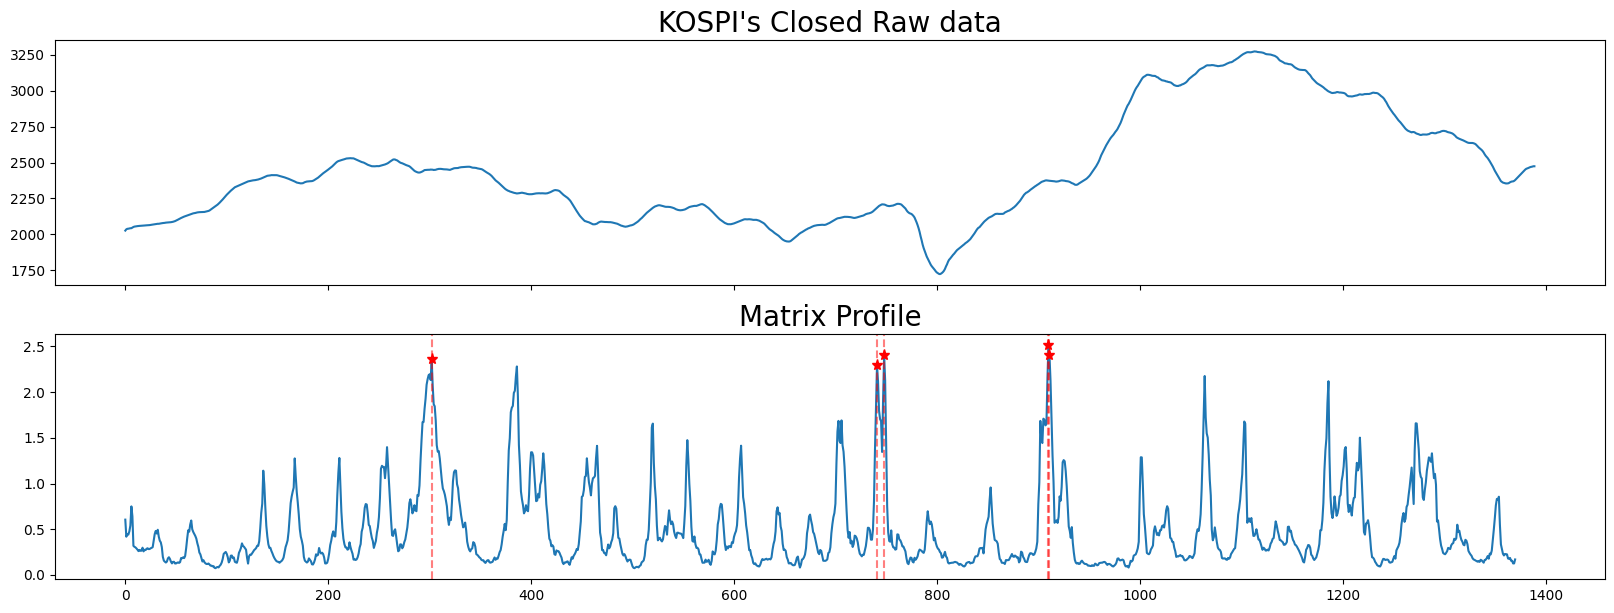

[910, 911, 748, 302, 741]
TOP 5 anomaly datetime
1's anomaly date : 2020-09-18 00:00:00
2's anomaly date : 2020-09-21 00:00:00
3's anomaly date : 2020-01-29 00:00:00
4's anomaly date : 2018-04-02 00:00:00
5's anomaly date : 2020-01-16 00:00:00


In [7]:
target = input("주식이름을 입력해주세요:")
analysis_anomaly(target)

# TF-IDF

In [8]:
# Find Datetime
datetime = []
for i in anomaly_datetime:
    datetime.append(i.strftime('%Y-%m-%d'))
datetime.sort()

start_datetime = datetime[0]
end_datetime = datetime[4]

print(start_datetime, end_datetime)


2018-04-02 2020-09-21


In [92]:
df_Kospi_data = pd.read_excel('./NewsResult_20200102-20200921.xlsx')
groups = df_Kospi_data.groupby(['키워드'])
groups2 = df_Kospi_data.groupby(['인용문'])
corpus = []
corpus2 = []
corpus = groups.head()['키워드'].tolist()
corpus2 = groups2.head()['인용문'].tolist()
items = ''.join(corpus)
items2 = ''.join(corpus2)
data = items.replace(',',' ')
document = []
document.append(data)
document.append(items2)

tfidf = TfidfVectorizer()
tfidf_vector = tfidf.fit_transform(document)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(20)

print(top_tfidf)
# =============================================================================
# vect = CountVectorizer()
# document_term_matrix = vect.fit_transform(corpus)

# tf = pd.DataFrame(document_term_matrix.toarray(), columns=vect.get_feature_names_out())
# columns = vect.get_feature_names_out()

# D = len(tf)
# df = tf.astype(bool).sum(axis=0)
# idf = np.log((D+1)/(df+1)) + 1

# tfidf = tf*idf
# tfidf = tfidf / np.linalg.norm(tfidf, axis=1, keepdims=True)

      document   term     tfidf
335          0    가능성  0.217751
4129         0     투자  0.202272
2417         0     시장  0.197968
3734         0     증시  0.167843
1783         0    변동성  0.146324
2336         0     수준  0.146324
3787         0     지수  0.146324
4229         0     펀드  0.146324
3591         0     주가  0.129110
2083         0     상승  0.124806
2148         0     상황  0.120502
4482         0     확대  0.116199
2116         0     상품  0.111895
248          0    etf  0.103288
2320         0    수익률  0.103288
3573         0     종목  0.103288
4054         0  코로나19  0.103288
4153         0   투자자들  0.102827
1612         0     미국  0.098984
1665         0     반등  0.098984
7807         1     있다  0.334196
5972         1     대한  0.220808
5194         1    것으로  0.196937
5006         1   가능성이  0.190969
7804         1     있는  0.185001
5476         1     국내  0.125324
5268         1     경우  0.107420
6074         1     따라  0.101452
8711         1  코로나19  0.097661
5420         1     관련  0.095485
8775    

c:\Users\dudgn\AppData\Local\Programs\Python\Python39\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

